# **dataset**

In [1]:
from transformers import AutoConfig,AutoModel,AutoTokenizer,AdamW,get_linear_schedule_with_warmup,logging,RobertaTokenizer,RobertaModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,SequentialSampler,RandomSampler,DataLoader

import pandas as pd

# 导入transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# 常用包
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
#二分类
excel = pd.read_excel("../input/eng-chi-pluse/chieng_small.xlsx") #
data=excel.values
df = pd.DataFrame(data,columns=['UBC','comment'])
df.head()

,UBC,comment
0,praise,Also very cool that they don't bombard you wit...
1,excessive network traffic,Bad reviews cheat browsing traffic software\t
2,fail to delete,videos in drafts should not be deleted after u...
3,ad disruption,Tried it out. I could never actually read an a...
4,fail to install,Why can't you install it... Cry~\t


In [5]:
mask = []
temp_comment = []
for label  in df.UBC:
  if (label=='ad disruption'):
    mask.append(1)
  else :
    mask.append(0)
for comment in df.comment:
    t = comment.replace('\n', '').replace('\t','')
    temp_comment.append(t)
df = pd.DataFrame({'UBC':df.UBC,'comment':temp_comment,'mask':mask})
print(df[:])

                              UBC  \
0                          praise   
1       excessive network traffic   
2                  fail to delete   
3                   ad disruption   
4                 fail to install   
...                           ...   
5496                fail to start   
5497               vulgar content   
5498    fail to login or register   
5499  privacy or information leak   
5500     fail to retrieve content   

                                                comment  mask  
0     Also very cool that they don't bombard you wit...     0  
1           Bad reviews cheat browsing traffic software     0  
2     videos in drafts should not be deleted after u...     0  
3     Tried it out. I could never actually read an a...     1  
4                      Why can't you install it... Cry~     0  
...                                                 ...   ...  
5496                    Crashes on start up. Samsung S7     0  
5497  It's amazing but you will stay on it 

In [8]:
ubc_names=df_ubc.index
df['UBC'].value_counts()

fail to install                                        526
vulgar content                                         487
ad disruption                                          462
payment deception                                      447
fail to start                                          390
fail to login or register                              379
bad performance                                        362
virus                                                  308
app repackaging                                        228
privacy or information leak                            226
fail to retrieve content                               215
excessive network traffic                              197
drive-by download                                      196
app ranking fraud                                      194
fail to delete                                         190
permission abuse                                       170
praise                                                 1

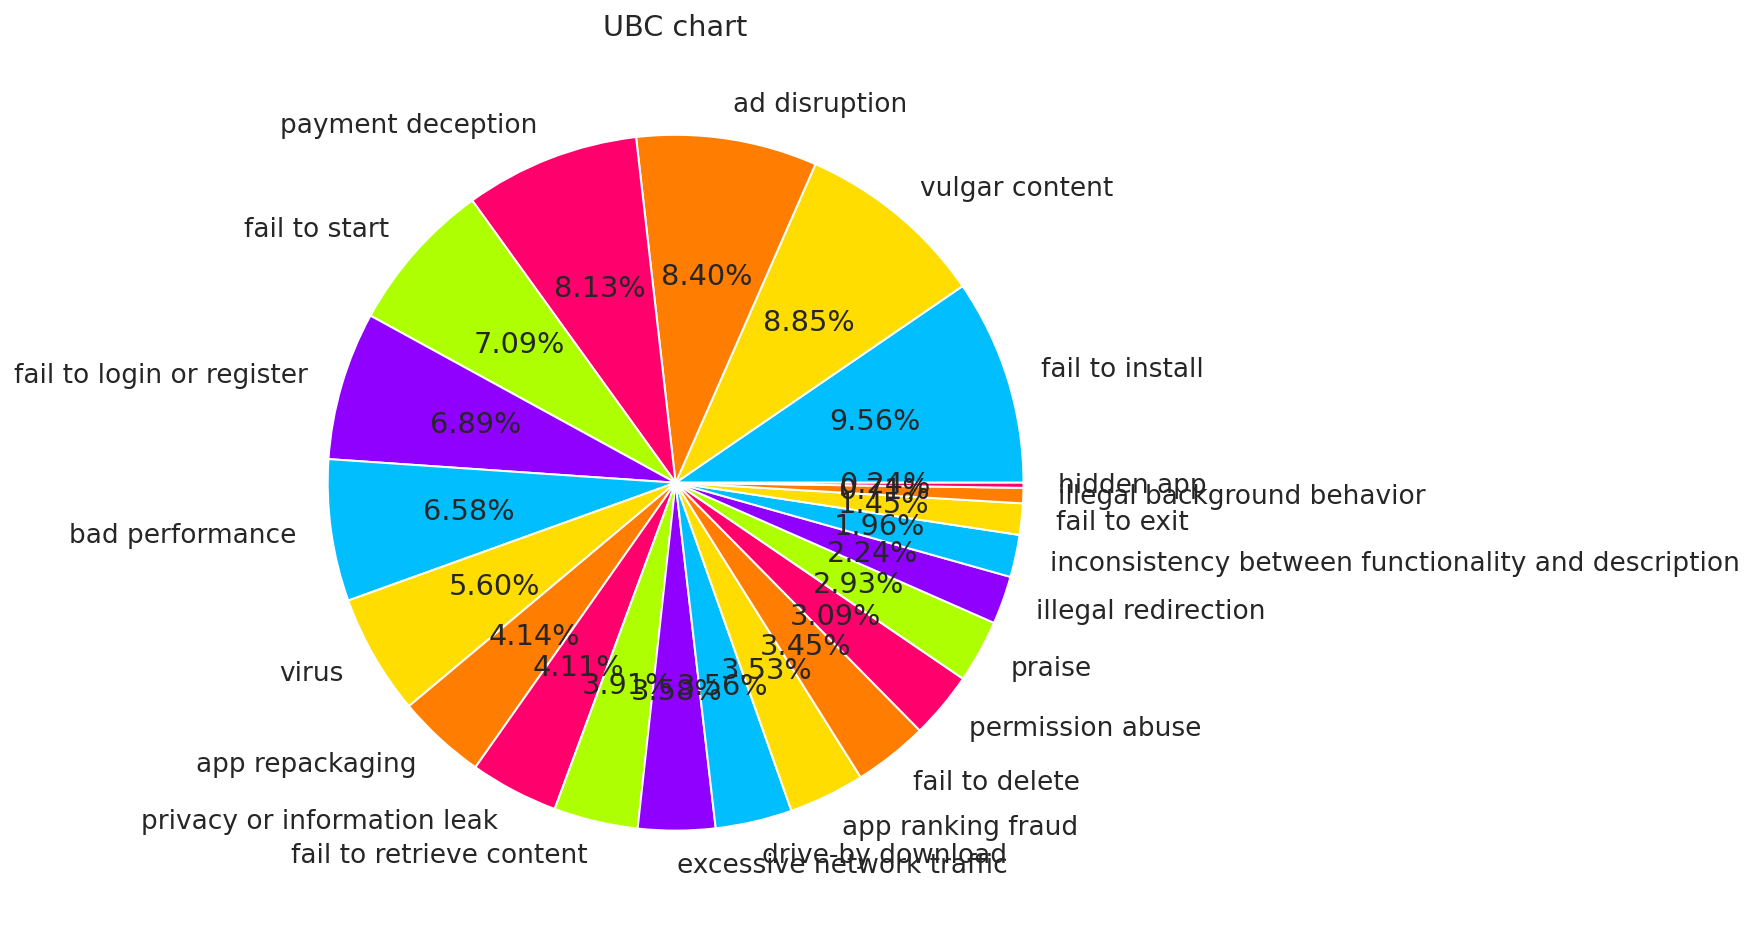

In [9]:
fig = plt.figure()
plt.pie(df_ubc,labels=ubc_names,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("UBC chart")
  
 
plt.show() 

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased' # 英文bert预训练模型
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
token_lens = []

for txt in tqdm(df.comment):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 5501/5501 [00:03<00:00, 1554.96it/s]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


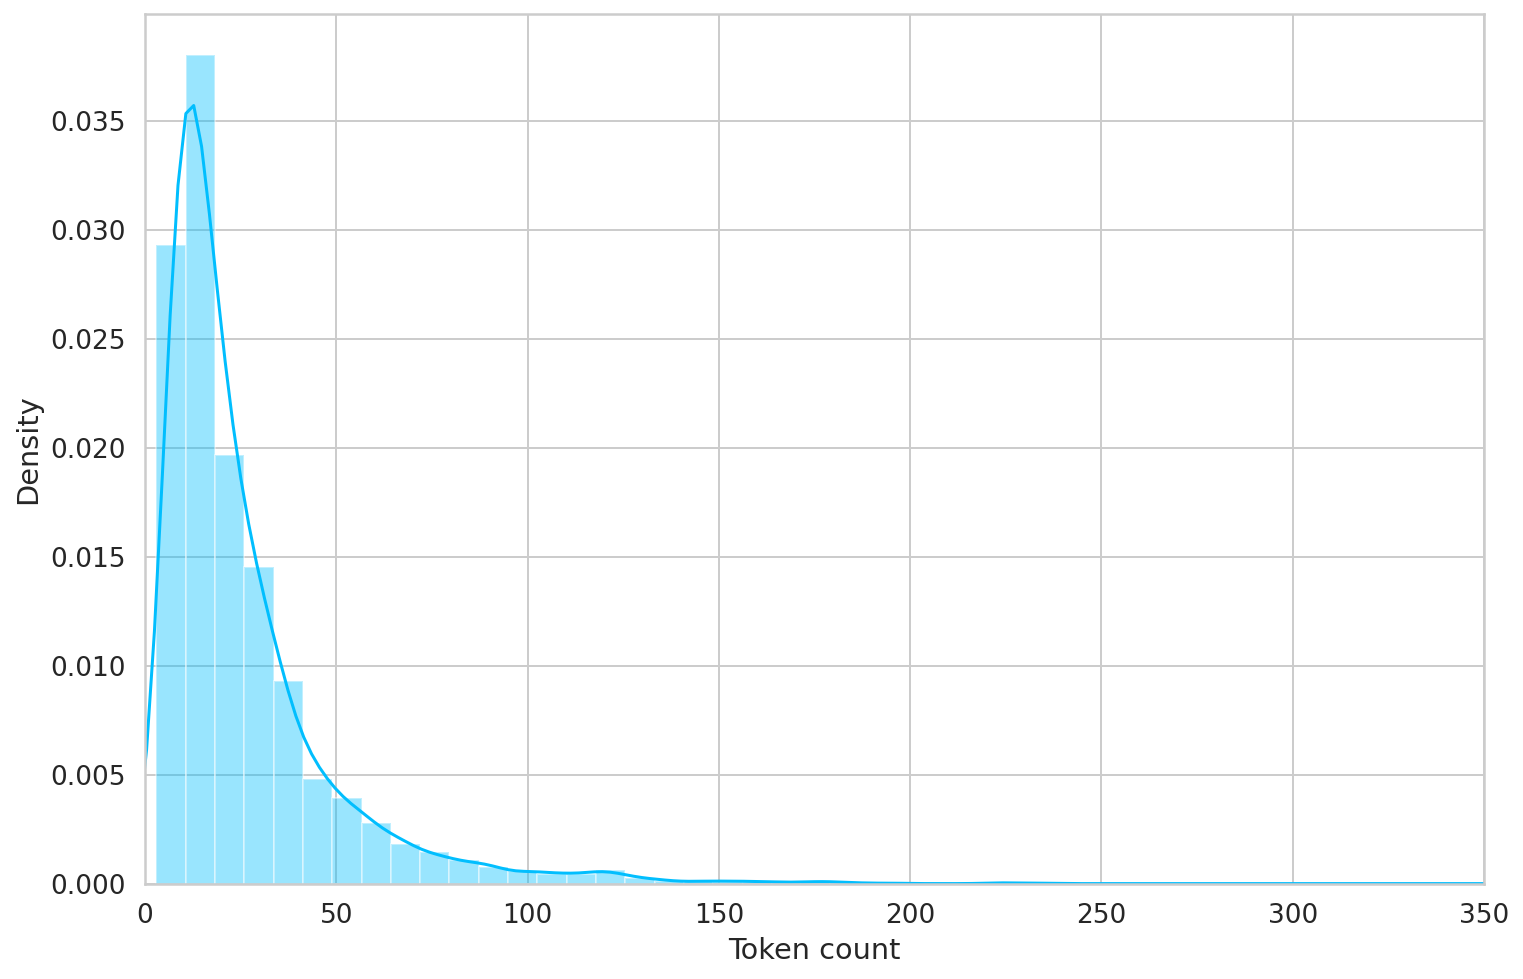

In [12]:
# MAX_LEN=300
MAX_LEN=350 # 选取max
sns.distplot(token_lens)
plt.xlim([0, 350]);
plt.xlabel('Token count');

In [13]:
pd.Series(token_lens).describe()

count    5501.000000
mean       25.574441
std        23.947612
min         3.000000
25%        11.000000
50%        18.000000
75%        31.000000
max       386.000000
dtype: float64

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((4400, 3), (550, 3), (551, 3))

# **binary**

In [15]:
#二分类
class CommentDataset(Dataset):
    def __init__(self,comments,labels,tokenizer,max_len):
        self.comments=comments
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.comments)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        comment=str(self.comments[item])
        label=self.labels[item]
        encoding=self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
#         print(encoding['input_ids'])
        return {
            'texts':comment,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }

In [16]:
#二分类
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=CommentDataset(
        comments=df['comment'].values,
        labels=df['mask'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
#         num_workers=4 # windows多线程
    )

In [17]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
#dataloader
next(iter(test_data_loader))

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'texts': ['[quote] the tree solitary moon knows that it is poisonous!!! [/ quote] Hello: what anti-virus software reports virus? Is it a poison report after installation?',
  "Can't the bill be deleted?",
  'Cheat people to spend money',
  "It's not easy to use. Once you operate the photo, it's gone"],
 'input_ids': tensor([[  101,  1031, 14686,  ...,     0,     0,     0],
         [  101,  2064,  1005,  ...,     0,     0,     0],
         [  101, 21910,  2111,  ...,     0,     0,     0],
         [  101,  2009,  1005,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0, 0, 0, 0])}

In [19]:
#classifier
class CommentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(CommentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output) # dropout
        return self.out(output)

In [20]:
#二分类
class_names = [1,0]

In [21]:
model = CommentClassifier(len(class_names))
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
EPOCHS = 3# 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [23]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader, position=0, leave=True):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
#二分类
from pandas import Series
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # 验证预测模式
    losses = []
    p_label = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device) 
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            p_label.append(preds.cpu().numpy()[0])
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    print("correct_predictions")
    print(correct_predictions)
    p = Series(p_label) 
    print("p.value_counts()") 
    print(p.value_counts())   
    return correct_predictions.double() / n_examples, np.mean(losses)


In [25]:
history = defaultdict(list) # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
#     if epoch%3==0:
#       chi_val()
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        ubc = 'ad'
        torch.save(model.state_dict(), '%s_model_state.bin'%ubc)
        best_accuracy = val_acc


Epoch 1/3
----------


100%|██████████| 1100/1100 [03:03<00:00,  6.00it/s]


Train loss 0.14349334148197984 accuracy 0.9684090909090909
correct_predictions
tensor(547, device='cuda:0')
p.value_counts()
0    123
1     15
dtype: int64
Val   loss 0.028192398732442045 accuracy 0.9945454545454545
Epoch 2/3
----------


100%|██████████| 1100/1100 [03:02<00:00,  6.03it/s]


Train loss 0.06073566358464053 accuracy 0.9872727272727273
correct_predictions
tensor(544, device='cuda:0')
p.value_counts()
0    123
1     15
dtype: int64
Val   loss 0.04421087369751215 accuracy 0.9890909090909091
Epoch 3/3
----------


100%|██████████| 1100/1100 [03:02<00:00,  6.03it/s]


Train loss 0.042344937725157995 accuracy 0.99
correct_predictions
tensor(546, device='cuda:0')
p.value_counts()
0    123
1     15
dtype: int64
Val   loss 0.02973991253334068 accuracy 0.9927272727272727


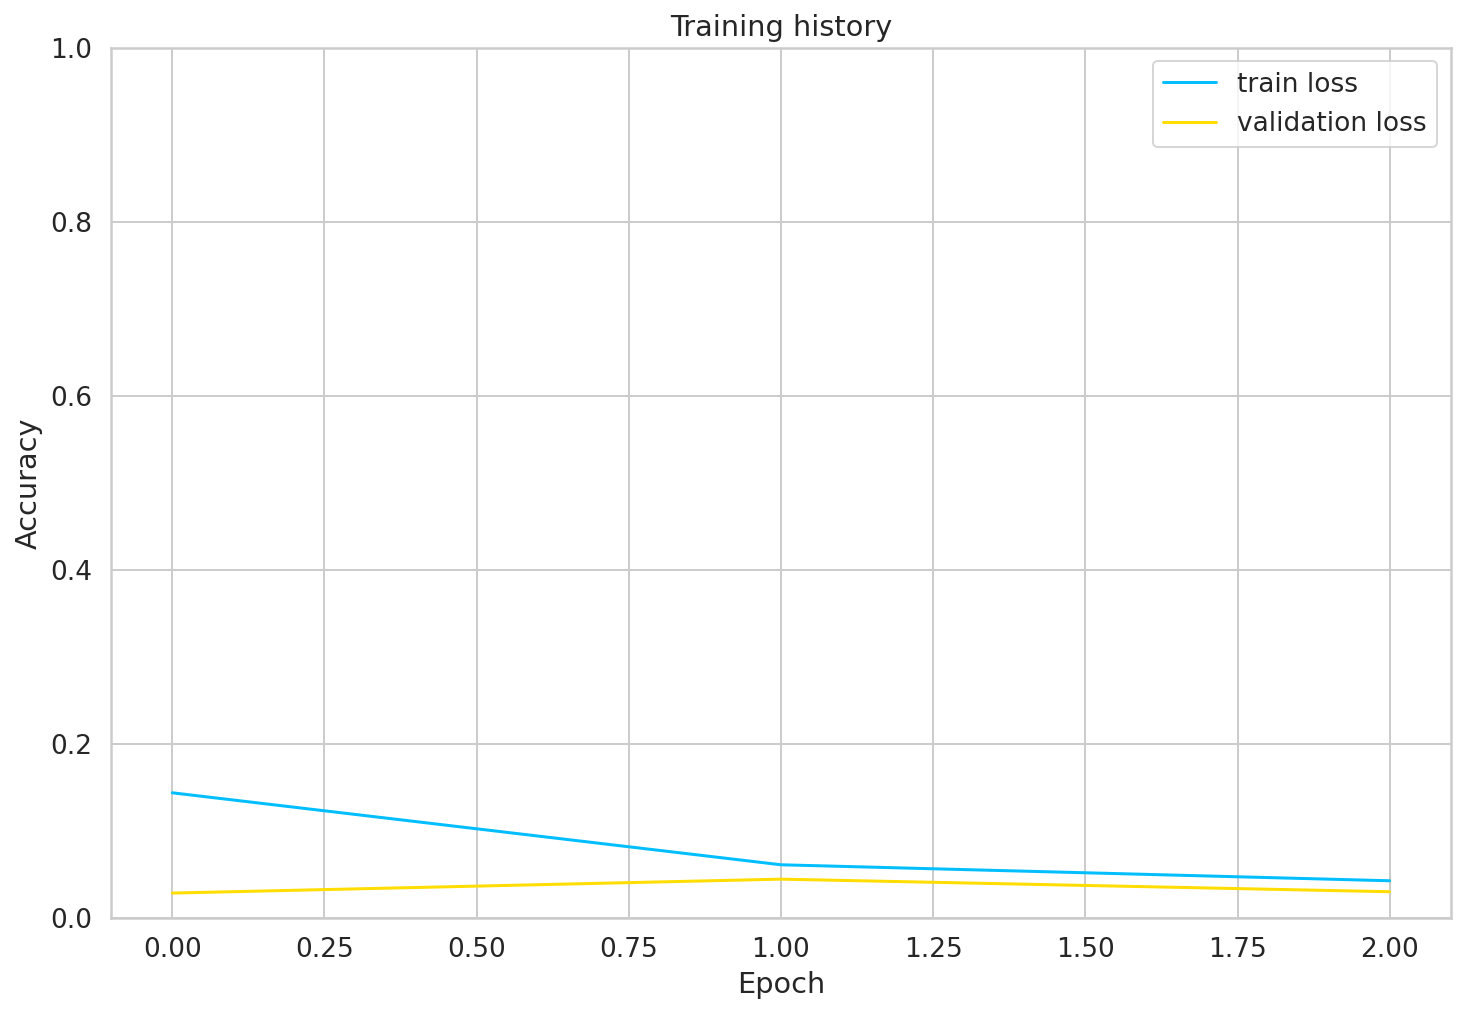

In [27]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [30]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

correct_predictions
tensor(543, device='cuda:0')
p.value_counts()
0    125
1     13
dtype: int64


0.9854809437386569

In [36]:
sample_text=' Solid game, few glitches,This ones a keeper! Edit: I see people complain that you cant get anywhere without spending money, not true at all! Best played every 3-4 hours'
encoded_text = tokenizer.encode_plus(
  sample_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
#encoded_text.input_ids

In [37]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sample text: {sample_text}')
print(f'Danger label  : {prediction.cpu().numpy()[0]}')

Sample text:  Solid game, few glitches,This ones a keeper! Edit: I see people complain that you cant get anywhere without spending money, not true at all! Best played every 3-4 hours
Danger label  : 0


In [38]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    predicts = []
    acc = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            predict = {preds.cpu().numpy()[0]}
            if predict==d["labels"] :
              acc.extend("1")
            else:
              acc.extend("0") 
            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            predicts.extend(predict)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return texts, predictions, prediction_probs, real_values ,predicts,acc

In [40]:
y_texts, y_pred, y_pred_probs, y_test, y_predicts, acc = get_predictions(
  model,
  test_data_loader
)

In [41]:
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names]))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       511
           0       0.88      0.93      0.90        40

    accuracy                           0.99       551
   macro avg       0.94      0.96      0.95       551
weighted avg       0.99      0.99      0.99       551



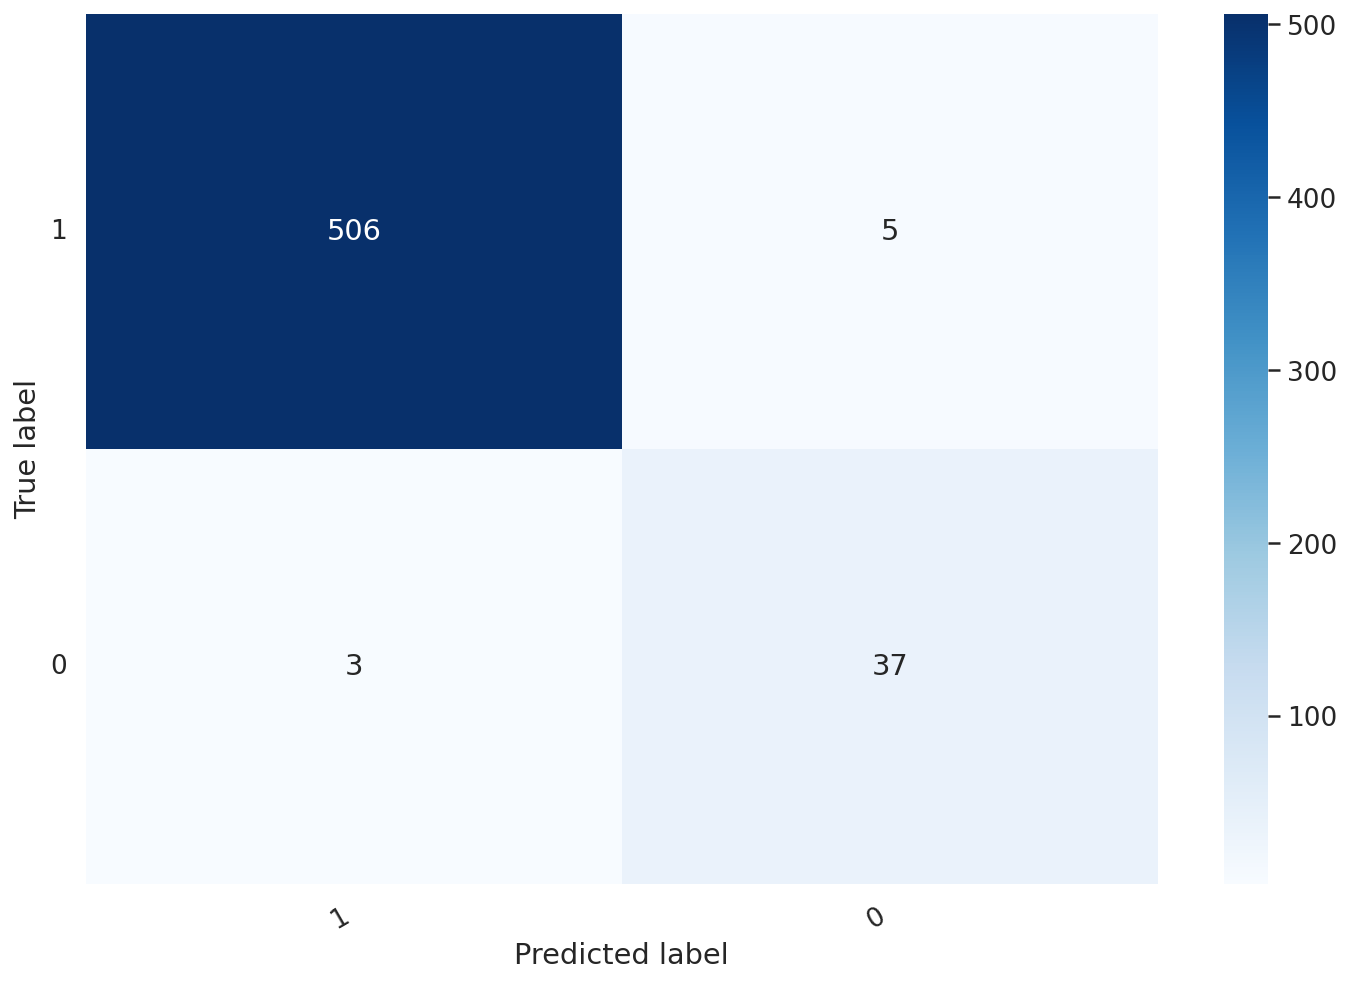

In [42]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# **model predict**

In [43]:
#第二代model_list
li = df['UBC'].unique()
li = li.tolist()
li.remove('praise') #after ranking 
#li.remove('hidden app')
li

['excessive network traffic',
 'fail to delete',
 'ad disruption',
 'fail to install',
 'fail to retrieve content',
 'fail to start',
 'drive-by download',
 'permission abuse',
 'vulgar content',
 'bad performance',
 'app ranking fraud',
 'fail to login or register',
 'privacy or information leak',
 'payment deception',
 'illegal redirection',
 'virus',
 'app repackaging',
 'inconsistency between functionality and description',
 'illegal background behavior',
 'fail to exit',
 'hidden app']

In [44]:
model_list = []
for l in li:
    model_list.append(l+"_model")
print(len(model_list))

21


In [45]:
def get_model(model_name):
  model = CommentClassifier(len(class_names))
  model = model.to(device)
  model.load_state_dict(torch.load('./%s_model.pth'%model_name))
  model = model.eval()
    
  return model

In [ ]:
#保存模型
for i in range(21):
  model_list[i]=get_model(li[i])

In [47]:
#eval 验证
def model_eval_predict(txt):
  label = []
  encoded_text = tokenizer.encode_plus(
    txt,
    max_length=400,
    add_special_tokens=True,
    return_token_type_ids=False,
    truncation='longest_first',
    padding=True,
    return_attention_mask=True,
    return_tensors='pt',
  )
  input_ids = encoded_text['input_ids'].to(device)
  attention_mask = encoded_text['attention_mask'].to(device)
  for i in range(21):
    ubc = li[i]
    model = model_list[i]
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    pre = prediction.cpu().numpy()[0]
    if (pre==1):
      label.append(ubc)
  return label